# Clusters by Demand
by LMZintgraf

### Imports.

In [1]:
import pandas as pd
import numpy as np
import time
from scipy.spatial.distance import cdist, pdist
import matplotlib.pyplot as plt
%pylab inline
# to make data categorical
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
# for clustering
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


### Parameters.

In [1]:
# specify if we want to use a subset (5%) of the data
use_subset = True
subsample_further = False

# directory where we store our features
path_datadrive = './input_data/'

In [2]:
# --- HYPERPARAMETERS FOR FEATURE EXTRACTION ---

# number of clusters to group depot/route/produc (if 0 will not be added as feature)
num_clusters_agencia = [25]
num_clusters_ruta = [100]
num_clusters_cliente = [150]
num_clusters_producto = [150]

### Load Data.

In [8]:
def get_data():

    # -> load the raw training and test data from kaggle
    
    train_path = './input-data/train_sampled5pct.csv' if use_subset else './input-data/train.csv'
    
    data = pd.read_csv(train_path, sep=',', dtype={'Semana': 'int8',
                                                         'Agencia_ID':'uint16',
                                                         'Canal_ID':'int8',
                                                         'Ruta_SAK':'int32',
                                                         'Cliente_ID':'int32',
                                                         'Producto_ID':'int32',
                                                         'Venta_uni_hoy': 'int8',
                                                         'Venta_hoy':'float32',
                                                         'Dev_uni_proxima':'int8',
                                                         'Dev_proxima':'float32',
                                                         'Demanda_uni_equil':'int32'})


    if subsample_further:
        data = train_data[::10]
        
    # remove unnecessary fields in training data
    data.drop(['Venta_uni_hoy', 'Venta_hoy','Dev_uni_proxima', 'Dev_proxima'], axis=1, inplace=True)
    
    # transform targets x -> log(x+1)
    data['Demanda_uni_equil'] = np.log1p(data['Demanda_uni_equil'])
    
    return data

# get the train, valid and test data we will use for our experiments
data = get_data()

# print the number of unique occurences
print(data.apply(lambda x: len(x.unique())))

id                   372370
Semana                    9
Agencia_ID              551
Canal_ID                  9
Ruta_SAK               2113
Cliente_ID           262812
Producto_ID            1196
Demanda_uni_equil       464
dtype: int64


### Clusters Creation.

#### (1) Cluster features by demand

In [9]:
def get_clusters_by_demand(feats, tars, num_clusters, feat_name):
    '''
    For a given feature vector, respective target vector, and number of clusters, returns
        - feats_unique: a list of unique feature values
        - clusters: for each unique feature, the cluster (ID) it belongs to
        - demand_info_unique: for each unique feature, some statistics about the demand for that feature
    '''
    # get the unique features which we then want to cluster
    feats_unique = np.unique(feats)
    
    # for each unique feature, we will get the mean/median/std demand
    demand_info_unique = np.zeros((len(feats_unique),2))
    for f in range(len(feats_unique)):
        all_orders = tars[feats==feats_unique[f]]
        demand_info_unique[f] = [np.median(all_orders), np.std(all_orders)]
        
    demand_info_unique[np.isnan(demand_info_unique)] = 0
        
    # we use the kmeans clustering algorithm
    kmeans = KMeans(num_clusters)
    clusters = kmeans.fit_predict(demand_info_unique)
    
    # plot demand/cluster
    plt.figure(figsize=(15, 3))
    for c in range(num_clusters):
        d_median = demand_info_unique[clusters==c,0]
        d_std = demand_info_unique[clusters==c,1]
        plt.plot(d_median,d_std,'.')
        plt.xlabel('median')
        plt.ylabel('std')
    plt.savefig(path_datadrive+'clustByDem_{}_{}'.format(feat_name, num_clusters))

    # return a mapping from unique feature values to clusters, and the demand info per cluster
    return feats_unique, clusters

In [10]:
def cluster_and_save(feat_name, num_clusters):
    '''
    Input: 
        - idx: the index of the feature we want to cluster, one-hot-encode, and add to our features
        - num_clusters: the number of clusters we want to use to group the feature values
    '''
    global data
    
    # run clustering by demand using info from week 3-9
    feats = data[feat_name][data["Semana"]<9].get_values()
    tars = data['Demanda_uni_equil'][data['Semana']<9].get_values()
    feats_unique, clusters = get_clusters_by_demand(feats, tars, num_clusters, feat_name)
    
    # create new dataframe to save cluster info
    clust_data = pd.DataFrame(data=data[['id', feat_name]], columns=['id', feat_name])
    clust_data.insert(1, feat_name+'_clust', 0)
    for f in range(len(np.unique(feats))):
        clust_data.loc[clust_data[feat_name]==feats[f],feat_name+'_clust'] = clusters[f]
    
    # get rid of the original feat info
    clust_data.drop([feat_name], axis=1, inplace=True)
        
    # save the new feature
    clust_data.to_csv(path_datadrive+"clustByDem_{}_{}".format(feat_name, num_clusters), index=False)

agencia... 25


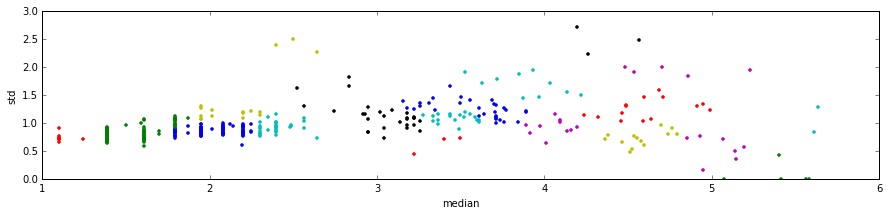

In [11]:
for c in num_clusters_agencia:
    print("agencia...", c)
    cluster_and_save('Agencia_ID', c)

ruta...  100


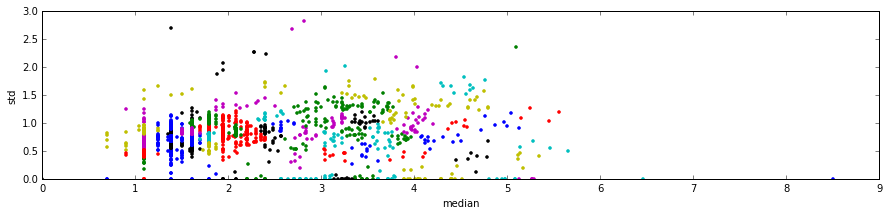

In [ ]:
for c in num_clusters_ruta:
    print("ruta... ", c)
    cluster_and_save('Ruta_SAK', c)

In [ ]:
for c in num_clusters_cliente:
    print("client...", c)
    cluster_and_save('Cliente_ID', c)

In [ ]:
for c in num_clusters_producto:
    print("prod...", c)
    cluster_and_save('Producto_ID', c)